In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

### Quelle der Daten: 
https://www.bundestag.de/services/opendata

### Erläuterungen
WP steht für Wahlperiode

In [2]:
DATA_PATH = Path('data')
MDB_XML_PATH = DATA_PATH / 'MDB_STAMMDATEN.XML'
DF_MDB_PATH = DATA_PATH / 'df_mdb.csv' #one row per individuum, one col per wp containing 0 / 1
DF_MDB_WP_PATH = DATA_PATH / 'df_mdb_wp.csv' # one row per individuum per wp, containting e.g. 12. so one abgeordneter who has been in parliament for several wp will receive one row per wp

# parse xml data into dataFrame / .csv fomat

In [3]:
def get_mdb_data(mdb_xml_path = MDB_XML_PATH):
    """get data frame of MDP data
    ID | NACHNAME | VORNAME |  ... | BERUF"""
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            mdb_dict[int(wahlperiode.find('WP').text)] = 1

        list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)

In [4]:
def get_mdb_wp_data(df_mdb):
    """
    reformat
    peter | lustig | wp1 | wp2
    
    into
    peter | lustig | wp1
    peter | lustig | wp2
    """
    
    wps = [column for column in df_mdb.columns if isinstance(column, int)] # probably 1 to 19 or 20
    columns_to_keep = [column for column in df_mdb.columns if not isinstance(column, int)] # 'BERUF', 'VITA_KURZ' etc
    
    # should be 19 before 2021, 20 afterwards
    max_wp = max(wps)
    
    # this could be optimized but only runs once for about 2 Minutes
    new_entries = []
    for idx, row in df_mdb.iterrows():
        for wp in wps:
            if row[wp] == 1:
                new_entry = row[columns_to_keep]
                new_entry['WP'] = wp
                new_entries.append(new_entry)
    
    mdb_wp = pd.DataFrame(new_entries)
    return(mdb_wp)

In [5]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [6]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

# compute Age

In [7]:
df_mdb['GEBURSDATUM_DATE'] = pd.to_datetime(df_mdb.GEBURTSDATUM)

In [8]:
df_mdb.head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,12,13,14,15,16,1,17,18,19,GEBURSDATUM_DATE
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930-10-20
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909-09-04
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913-05-26
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1933-06-11
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1950-09-06


In [9]:
wp_startdaten = {
    1:datetime(1949, 9, 7), # Der 1. Deutsche Bundestag bestand zwischen dem 7. September 1949[1] und dem 7. September 1953
    2:datetime(1953, 10, 6), # Der 2. Deutsche Bundestag bestand zwischen dem 6. Oktober 1953[1] und dem 6. Oktober 1957
    3:datetime(1957, 10, 15), # Der 3. Deutsche Bundestag bestand zwischen dem 15. Oktober 1957[1] und dem 15. Oktober 1961
    4:datetime(1961, 10, 17), # Der 4. Deutsche Bundestag bestand zwischen dem 17. Oktober 1961[1] und dem 17. Oktober 196
    5:datetime(1965, 10, 19), # Der 5. Deutsche Bundestag bestand zwischen dem 19. Oktober 1965[1] und dem 19. Oktober 1969
    6:datetime(1969, 10, 20), # Der 6. Deutsche Bundestag bestand zwischen dem 20. Oktober 1969[1] und dem 13. Dezember 1972
    7:datetime(1972, 12, 13), #? Der 7. Deutsche Bundestag wurde am 19. November 1972 gewählt
    8:datetime(1976, 12, 14), # Der 8. Deutsche Bundestag bestand zwischen dem 14. Dezember 1976[1] und dem 4. November 1980
    9:datetime(1980, 11, 4),# Der 9. Deutsche Bundestag bestand zwischen dem 4. November 1980[1] und dem 29. März 1983
    10:datetime(1983, 3, 29), # Der 10. Deutsche Bundestag bestand zwischen dem 29. März 1983[1] und dem 18. Februar 1987
    11:datetime(1987, 2, 18), # Der 11. Deutsche Bundestag bestand zwischen dem 18. Februar 1987[1] und dem 20. Dezember 1990
    12:datetime(1990, 12, 20), # Der 12. Deutsche Bundestag bestand zwischen dem 20. Dezember 1990[1] und dem 10. November 1994
    13:datetime(1994, 11, 10), # Der 13. Deutsche Bundestag bestand zwischen dem 10. November 1994[1] und dem 26. Oktober 1998
    14:datetime(1998, 10, 26), # Der 14. Deutsche Bundestag bestand zwischen dem 26. Oktober 1998[1] und dem 17. Oktober 2002
    15:datetime(2002, 10, 17), # Der 15. Deutsche Bundestag bestand zwischen dem 17. Oktober 2002[1] und dem 18. Oktober 2005
    16:datetime(2005, 10, 18), # Der 16. Deutsche Bundestag bestand zwischen dem 18. Oktober 2005[1] und dem 27. Oktober 2009
    17:datetime(2009, 10, 27), # Der 17. Deutsche Bundestag bestand zwischen dem 27. Oktober 2009[1] und dem 22. Oktober 2013
    18:datetime(2013, 10, 22), # Der 18. Deutsche Bundestag bestand vom 22. Oktober 2013 bis zum 24. Oktober 2017
    19:datetime(2017, 10, 24) #  Seine konstituierende Sitzung fand am 24. Oktober 2017 statt,
}

df_wp_startdaten=pd.DataFrame(wp_startdaten, index=[0]).T
df_wp_startdaten.columns =[ 'START_DATE']
print(df_wp_startdaten.head())
df_wp_startdaten.to_csv('data/wp_startdaten.csv')

  START_DATE
1 1949-09-07
2 1953-10-06
3 1957-10-15
4 1961-10-17
5 1965-10-19


## Insight: es werden immer mehr Abgeordnete

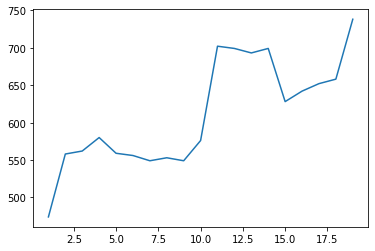

In [10]:
wps = [column for column in df_mdb.columns if isinstance(column, int)]
fig, ax = plt.subplots()#plt.figure(figsize=(8,6))

# xlab / ylab not showing is nb issue
plt.xlabel='WP'
plt.ylabel='Anzahl Abgeordneter'
#plt.plot(df_mdb[wps].sum().sort_index())
df_mdb[wps].sum().sort_index().plot()
plt.show()

In [11]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [12]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock'].iloc[0].VITA_KURZ)

('2000/04 Studium der Politikwissenschaft und Öffentliches Recht in Hamburg; '
 '2000/03 freie Mitarbeit bei der Hannoverschen Allgemeinen Zeitung; 2005 '
 'Master im Völkerrecht (LL.M.) an der LSE London; 2005/08 Büroleiterin der '
 'Europaabgeordneten Elisabeth Schroedter in Brüssel und Potsdam. 2008/09 '
 'Referentin für Außen- und Sicherheitspolitik bei der Grünen '
 'Bundestagsfraktion. 2009/13 Landesvors. BÜNDNIS 90/DIE GRÜNEN Brandenburg. '
 'Seit 2005 Mitgl. von Bündnis 90/Die Grünen, 2009/12 Mitgl. im Vorstand der '
 'Europäischen Grünen Partei; 2012/15 Mitgl. im Parteirat von Bündnis 90/Die '
 'Grünen, seit Jan. 2018 Bundesvors. von Bündnis90/Die Grünen. Englisch (f), '
 'Französisch (G), Spanisch (G). - MdB seit Okt. 2013.')


# clean data 1. missing values

In [14]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [15]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replace values: PARTEI_KURZ

In [16]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [17]:
# some cleaning necessary: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90' => 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

# replace values: RELIGION

In [18]:
df_mdb['RELIGION_MAPPED'] = df_mdb['RELIGION']
df_mdb.RELIGION_MAPPED.value_counts().head(12)

ohne Angaben              1214
evangelisch               1154
katholisch                 870
römisch-katholisch         316
UNBEKANNT                  227
evangelisch-lutherisch     138
konfessionslos             118
evangelisch-reformiert      15
religionslos                 7
Atheistin                    6
muslimisch                   5
Islam                        3
Name: RELIGION_MAPPED, dtype: int64

In [19]:
for katholisch_alias in ['römisch-katholisch', 'alt-katholisch']:
    df_mdb['RELIGION_MAPPED'].replace(katholisch_alias, 'katholisch', inplace=True)

In [20]:
for evangelisch_alias in ['evangelisch-lutherisch', 'evangelisch-reformiert', 'evangelisch-freikirchlich', 'protestantisch']:
    df_mdb['RELIGION_MAPPED'].replace(evangelisch_alias, 'evangelisch', inplace=True)

In [21]:
# it's not the same but its similar
for konfessionslos_alias in ['religionslos', 'Atheist', 'Atheistin']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'konfessionslos', inplace=True)

In [22]:
for konfessionslos_alias in ['Islam']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'muslimisch', inplace=True)

In [23]:
# erkenntnis: nur christen und einige wenige konfessionslose
df_mdb['RELIGION_MAPPED'].value_counts().head(24)

evangelisch            1311
ohne Angaben           1214
katholisch             1187
UNBEKANNT               227
konfessionslos          133
muslimisch                8
freireligiös              3
neuapostolisch            1
griechisch-orthodox       1
orthodox                  1
alevitisch                1
russisch-orthodox         1
humanistisch              1
Name: RELIGION_MAPPED, dtype: int64

<AxesSubplot:>

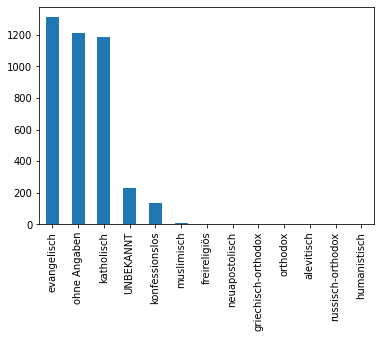

In [24]:
df_mdb['RELIGION_MAPPED'].value_counts().plot(kind='bar')

# replace values: FAMILIENSTAND

In [25]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb['FAMILIENSTAND_MAPPED'] = df_mdb['FAMILIENSTAND']
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('verheiratet', 'verh.'))
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('geschieden', 'gesch.'))
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., 4 Kinder",251
ledig,202
"verh., 5 Kinder",98
UNBEKANNT,81


In [26]:
indikator = re.compile('^verh.,\s([4-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'verh., >3 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'verh., 6 Kinder', 'verh., 12 Kinder', 'verh., 9 Kinder', 'verh., 4 Kinder', 'verh., 7 Kinder', 'verh., 5 Kinder', 'verh., 8 Kinder', 'verh., 10 Kinder'}


/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [27]:
indikator = re.compile('^gesch.,\s([1-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'gesch., >0 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'gesch., 3 Kinder', 'gesch., 5 Kinder', 'gesch., 1 Kind', 'gesch., 4 Kinder', 'gesch., 2 Kinder'}


In [28]:
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., >3 Kinder",422
ledig,202
UNBEKANNT,81
"gesch., >0 Kinder",80


# replace values: BERUFE

In [29]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [30]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [31]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47
Kaufmann,45
Journalist,43
Hausfrau,41


In [32]:
from importlib import reload
import berufe_mapping 
reload(berufe_mapping)
from berufe_mapping import basic_cleaning_berufe

'''very basic cleaning: lowercasing, removing dipl., (fh) and a.d.'''
df_mdb = basic_cleaning_berufe(df_mdb , column = 'BERUF_MAPPED')

In [33]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF_MAPPED,
rechtsanwalt,373
geschäftsführer,111
landwirt,105
-ingenieur,101
-volkswirt,82
lehrer,75
jurist,73
angestellter,73


In [34]:
re.sub('regierungs(vize)*präs', 'XX', 'abc regierungspräsident xjsk regierungsvizepräsidentin')

'abc XXident xjsk XXidentin'

In [35]:
dict_berufe={}
dict_berufe['Jurist*in'] = ['anwalt', 'jurist', 'richter', 'notar', re.compile('dr.*\s*jur.*'), 'syndikus', 'rechtsberater']
dict_berufe['Land-/Forstwirt*in'] = ['landwirt', '^[a-z]bauer\s', 'bauer', re.compile('agrar+'), 'forst']
dict_berufe['Unterehmer*in'] = ['unternehmer'] # geschäftsführer geht leider nicht wegen z.B. Parl. Geschäftssführer
dict_berufe['Ingenieur*in'] = ['ingenieur', 'maschinenbau', 'architekt']
dict_berufe['Journalist*in'] = ['journalist', 'redakteur', 'publizist', 'schriftsteller']
dict_berufe['Verleger*in'] = ['verleger', 'verlags']

# direktor: nö, sonst bezirksdirektor museumsdirektor etc
dict_berufe['Lehrer*in'] = ['erzieher', 'pädagog', 'lehrer', 'studienrat', 'studiendirektor', 'schulrat',
                            'grundschul', 'hauptshul', 'sonderschul', 'waldorf', 'realschul', 'gymnasi',
                            'volkshochschu', 'berufsschul', 'fremdsprachen',
                           'schul'] #evtl trennen Erzieher - Lehrer
dict_berufe['Professor*in'] = ['dozent', 'professor', 'prof.', 'hochschull', 'hochschulpr']
dict_berufe['Kaufmann/-frau'] = ['kaufm']
dict_berufe['Volkswirt*in'] = ['volkswirt']
dict_berufe['Berufspolitiker*in'] = ['regierungsangestellt', 'stadtamtmann', 'stadtoberinspektor', 'Landesgeschäftsführer',
                                    'landr(at|ätin)', re.compile('ministerialr(a|ä)t'), 'staatssekret', 'bürgermeist', 
                                     'regierungsrat', re.compile('regierungs(vize)*präs'), 'regierung',
                                     'stadtdirektor', 'ministerialdirektor', 'regierungsdirektor', 'gemeindedirektor', 'regierungsdirektor',
                                     'minister', 'bundeskanz', 'bundestagsp', re.compile('präsident(in)* d\.*b\.*t\.*')]
dict_berufe['Arzt/Ärztin'] = ['arzt', 'psycholog', 'psychother', 'apotheker']
dict_berufe['Theolog*in'] = ['pfarrer', 'theolog', 'diakon']
dict_berufe['Betriebswirt*in'] = ['betriebswirt', 'verwaltungs', 'steuerberater', 'bankdirektor']
dict_berufe['Wirtschaftswissenschaftler*in'] = ['wirtschaftsw', 'ökonom', 'prokurist']
dict_berufe['Geisteswissenschaftler*in'] = ['politolog', 'politikwiss', 'historik', 'philosoph', 'philolog', 'soziolog', 'sozialwissensch', 'kulturwissenschaft']
dict_berufe['Naturwissenschaftler*in'] = ['chemik', 'chemie', 'physik', 'geophysik', 'biolog', 'mathemat', 'informat']

dict_berufe['Handwerker*in'] = ['elektro', 'fahrzeug', 'handwerk', 'mechanik',
                               'schlosser', 'maurer', 'beton', 'maler', 'lackier', 'tischler', 'schreiner',
                               'bäcker', 'konditor' 'koch', 'köchin', 'müller', 'bergmann', 'werkzeugmacher']
dict_berufe['Militär'] = ['leutnant', 'oberst^u', 'soldat', re.compile('general\s')] # not oberstudienrat ;)
dict_berufe['Beamter'] = ['beamter']# problematisch: Berufspolitiker, Lehrer, Militär sind auch beamte

In [36]:
re.sub('oberst[^u]', 'X', 'oberst oberst oberst')

'XXoberst'

In [37]:
def replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb):
    values_to_replace = set()
    # TODO without loop but use 'any'
    for indikator in dict_berufe[berufsklasse]:
        values_to_replace = values_to_replace.union(set(df_mdb[df_mdb.BERUF_MAPPED.str.contains(indikator)].BERUF_MAPPED))

    print(values_to_replace)
    df_mdb.replace(list(values_to_replace), berufsklasse, inplace=True)
    return(df_mdb)

In [38]:
df_mdb = replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb)

{'richterin am kammergericht', 'jurist (richter)', 'staatsanwalt', 'generalbundesanwalt', 'familienrichterin', 'rechtsanwalt u. notar', 'jurist', 'richterin', 'richter', 'richter am oberverwaltungsgericht', 'notar', 'rechtsanwaltsgehilf', 'richterin am amtsgericht', 'richterin a. lg.', 'oberamtsrichter', 'rechtsanwalt f. steuerrecht', 'syndikus', 'rechtanwalt', 'handwerkskammersyndikus', 'rechtsberater', 'höherer dienst bund/land (ministerialrat); landrat; rechtsanwalt', 'richterin am landgericht', 'steuerjurist', 'richter am oberlandesgericht', 'handelskammersyndikus', 'wirtschaftsjurist', 'syndikusanwalt', 'rechtsanwalt', 'vorsitzender richter am landgericht', 'rechtsanwalt (tätigkeit ruhend)', 'richterin i. r.', 'rechtsanwalts-', 'volljurist', 'richter am landgericht', 'richter am bundesgerichtshof', 'verwaltungsjurist', '-jurist', 'dr. jur.', 'richter i. r.', 'oberstaatsanwalt'}


In [39]:
df_mdb = replace_berufsklasse(berufsklasse = 'Land-/Forstwirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'-agraringenieur', 'bauer', 'agrarwissenschaftler', '-landwirt', 'forstmeister i. r.', 'schiffbauer', 'oberregierungslandwirtschaftsrat', '-forstingenieur', 'stahlbetonbauer', 'landwirtschaftsrat', 'landwirt', 'landwirtschaftsmeister', 'landwirtschaftsdirektorin', 'oberlandwirtschaftsrat', 'straßenbauer', 'agrarreferent', 'selbstständiger landwirt', 'agraringenieur', 'betonbauer', 'austragbauer', '-agraringenieurin', 'land- u. forstwirt', 'forstoberrat', '-forstwirt', 'forstwirt', 'hochschulagraringenieur', 'maschinenbauer'}


In [40]:
df_mdb = replace_berufsklasse(berufsklasse = 'Unterehmer*in', dict_berufe = dict_berufe, df = df_mdb)

{'bauunternehmer', 'selbständiger unternehmer', 'speditionsunternehmer', 'selbst. unternehmer', 'handwerksunternehmer', 'unternehmer', 'transportunternehmer', 'selbstständiger unternehmer'}


In [41]:
df_mdb = replace_berufsklasse(berufsklasse = 'Ingenieur*in', dict_berufe = dict_berufe, df = df_mdb)

{'-wirtschaftsingenieurin', 'ingenieur', 'maschinenbaumeister', '-ingenieurökonom', 'maschinenbauingenieur', '-maschinenbauingenieur', 'ingenieur (gr', '-ingenieur', '-ingenieurin  lebensmittelkonservierer', '-wirtschaftsingenieur', 'ingenieurökonom', '-meliorationsingenieur', 'elektroingenieur', 'architekt bda', 'freie innenarchitekt', '-bauingenieur', '-ingenieurin  fb architektur', 'öffentlich bestellter vermessungsingenieur', 'bergingenieur', 'betriebsingenieur', 'textilingenieur', 'wirtschaftsingenieur', '-ingenieurin', '-ingenieur (tu)', '-elektroingenieur', '-chemieingenieur', 'bauingenieur', '-ing.  architekt', 'architekt', 'vertriebsingenieur', 'gartenarchitekt', '-innenarchitekt', 'hochschulingenieur', 'chemieingenieur', 'bauingenieur (gr', 'oberingenieur'}


In [42]:
len(set(df_mdb.BERUF_MAPPED))

1001

In [43]:
df_mdb = replace_berufsklasse(berufsklasse = 'Journalist*in', dict_berufe = dict_berufe, df = df_mdb)

{'redakteur', 'freiberufliche redakteur', 'rundfunk-redakteur', 'chefredakteur', 'journalist', 'publizist', 'politischer redakteur', 'wissenschaftlicher redakteur', 'schriftsteller', 'pr-journalist', 'fernsehjournalist', 'freie journalist', 'freier journalist'}


In [44]:
df_mdb = replace_berufsklasse(berufsklasse = 'Lehrer*in', dict_berufe = dict_berufe, df = df_mdb)

{'hochschullehrer', 'berufschullehrer', 'sonderschulpädagog', 'hochschulprofessor', 'lehrerin (strin)', 'lehrerin', 'volkshochschulangestellter', 'schulamtsleiter', 'fachhochschulprofessor', 'volksschulrektor', 'oberlehrer', 'hauptschuldirektor', 'fachschuldozent', '-sozialpädagog', '-pädagoge', 'reallehrer', '-religionspädagoge', 'gymnasiallehrer', 'schulrat', 'realschulrektor', 'hochschuldozent', 'sttschuldirektor', 'schulrätin', 'pädagoge', 'oberstudienrat', 'pädagogin m a', 'gewerbeschullehrer', 'leitender gesamtschuldirektor', 'sozialpädagogin gr', '-ing. pädagoge', 'lehrer am katholischen gymnasium ravensburg', '-lehrer', 'sonderschullehrer', 'studiendirektor im privatschuldienst', 'realschulektorin', 'gymnastiklehrer', '-lehrer biologie/chemie', 'sozialpädagoge', 'pädagogische mitarbeiter', '-medizinpädagoge', '-pädagogin', 'lehrer am gymnasium (oberstudienrat)', 'oberschulrat i. r.', 'lehrerin im hochschuldienst', 'technischer lehrer', 'schulamtsdirektor', 'schuldirektor', 'leh

In [45]:
df_mdb = replace_berufsklasse(berufsklasse = 'Kaufmann/-frau', dict_berufe = dict_berufe, df = df_mdb)

{'-kaufmann', 'kaufmännischer direktor', 'außenhandelskaufmann', 'kaufmännischer angestellter', 'mineralölkaufmann', 'selbstständige industriekaufmann', 'versicherungskaufmann', 'wirtschaftskaufmann', 'werbekaufmann', 'immobilienkaufmann', 'viehkaufmann', 'industriekaufmann', 'speditionskaufmann', 'selbstständiger kaufmann', 'pharmazeutisch kaufmännische assistent', 'versichrungskaufmann', 'hotelkaufmann', 'datenverarbeitungskaufmann', 'kaufmann im einzelhandel', 'kaufm. angestellte', 'baukaufmann', 'verlagskaufmann', 'selbständiger kaufmann', 'großhandelskaufmann', 'bankkaufmann', 'einzelhandelskaufmann', 'reisebürokaufmann', 'bürokaufmann', 'reiseverkehrskaufmann', '-kaufmann (univ.)', 'technischer kaufmann', 'kaufmännische angestellte', 'schifffahrtskaufmann', 'grundstücks- u. wohnungswirtschaftskaufmann', '-kaufmann wp/stb', 'textilkaufmann', 'kaufm.angestellter', 'kaufmann', 'selbst. kaufmann', 'kaufmännische angest.', 'selbständiger einzelhandelskaufmann'}


In [46]:
df_mdb = replace_berufsklasse(berufsklasse = 'Professor*in', dict_berufe = dict_berufe, df = df_mdb)

{'universitätsprofessor', 'dozent', 'studienprofessor', 'honorarprofessor', 'professor', 'professor der betriebswirtschaft', 'ordentlicher universitätsprofessor', 'o. professor', 'ordentlicher professor', 'universitätsprofessor der rechte', 'o. universitätsprofessor', 'prof.'}


In [47]:
len(set(df_mdb.BERUF_MAPPED))

844

In [48]:
df_mdb = replace_berufsklasse(berufsklasse = 'Volkswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'-volkswirt', 'volkswirt', 'volkswirtschaftler', 'technischer -volkswirt', 'volkswirt (gr', '-volkswirt (uni)', '-volkswirt (universität)'}


In [49]:
df_mdb = replace_berufsklasse(berufsklasse = 'Berufspolitiker*in', dict_berufe = dict_berufe, df = df_mdb)

{'landesminister', 'regierungsvizepräsident', 'staatsmister beim bundesminister der auswärtigen', 'staatssekretärin', 'staatssekretär', 'bürgermeisterin', 'ministerialrat', 'ministerpräsident', 'staatsminister', 'staatssekretär im ministerium', 'regierungsrätin', 'oberregierungsrat  bundesminister', 'parlamentarischer staatssekretär', 'wirtschaftsminister u. stellvertr. ministerpräsident', 'oberbürgermeister', 'parl. staatssekretär im bmbf', 'bundesminister des auswärtigen', 'vizepräsidentin dbt', 'referent (staatsministerium)', 'präsidentin dbt', 'ministerialdirigent', 'landesministerin  (bb)', 'ministerialdirektor', 'bundesminister des innern', 'regierungsrät', 'bundesminister', 'erster bürgermeister', 'landrat', 'ministerialdirektor i. r.', 'amtsbürgermeister', 'parl. staatssekretärin', 'regierungsinspektor', 'bundesminister f. besondere aufgaben', 'oberregierungsrat', 'referentin landesministerium nrw', 'staatssekretär i. r.', 'bürgermeister i. r.', 'regierungsdirektorin', 'ministe

/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [50]:
df_mdb = replace_berufsklasse(berufsklasse = 'Arzt/Ärztin', dict_berufe = dict_berufe, df = df_mdb)

{'-psycholog', '-psychologe', 'zahnarzt', 'tierarzt', 'praktischer arzt', 'mannenarzt', 'arzt allgemein/ tropenmediz', 'psycholog', 'kinderarzt', 'werksarzt', 'apotheker', 'arzt', 'facharzt', 'beratender psychologe', 'fachpsychologin der mediz', 'chefarzt im bezirkskrankenhaus schwer'}


In [51]:
df_mdb = replace_berufsklasse(berufsklasse = 'Theolog*in', dict_berufe = dict_berufe, df = df_mdb)

{'-theologe', 'theolog', 'pfarrer im wartestand', 'pfarrer i. r.', 'pfarrer', 'diakon', 'theologe'}


In [52]:
df_mdb = replace_berufsklasse(berufsklasse = 'Betriebswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'-verwaltungswirtin', 'verwaltungsangestellte', 'städtischer ltd. verwaltungsdirektor', 'verwaltungsdirektor', '-verwaltungswirt polizei', 'verwaltungs-', '-betriebswirtin  amtmann', '-verwaltungswissenschaftler', '-betriebswirtschaftler', 'verwaltungsfachangestellter', 'kreisverwaltungsdirektor', 'betriebswirt', 'landesoberverwaltungsrat', 'verwaltungsoberinspektor', 'sparkassenbetriebswirt', 'steuerberater', 'verwaltungsvollzugsbeamter', 'verwaltungsrat', 'verwaltungsamtmann', 'betriebswirt (vwa)', '-verwaltungswirt', 'kreisverwaltungsreferent', 'bundesbankdirektor', '-bankbetriebswirt (fs)', 'verwaltungsamtmann (sachbearbeiter)', '-betriebswirt', 'betriebswirtin (vwa)', 'betriebswirtin sgd', 'verwaltungsamtsrat', 'sttverwaltungsrat', 'rechtskundige verwaltungsdirektorin', 'verwaltungsratsvorsitzender', 'verwaltungsangestellter', 'verwaltungsleiter', 'verwaltungsfachwirt', 'verwaltungsinspektor', 'verwaltungsbeamter', 'verwaltungswirt', 'bankdirektor', 'selbständige steuerberater', 

In [53]:
df_mdb = replace_berufsklasse(berufsklasse = 'Wirtschaftswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'-ökonom', 'prokurist', '-sozialökonom', 'ing.-ökonom', 'wirtschaftswissenschaftler', 'personalmanagementökonomin (vwa)', 'ökonomierat', 'ökonom'}


In [54]:
df_mdb = replace_berufsklasse(berufsklasse = 'Geisteswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'politikwissenschaftliche doktorand', '-philosoph', '-politikwissenschaftler', 'kunsthistoriker', 'literaturhistoriker', 'soziologe', 'soziolog', 'politikwissenschaftler ma', '-politolog', 'politikwissenschaftler', 'politikwissenschaftler (m. a.)', 'politologe', '-sozialwissenschaftler', '-politologe', '-soziolog', '- politolog', 'politikwissenschaftler m. a.', 'philologe', 'kulturwissenschaftler', 'politikwissenschaftler (m.a.)', 'politolog', 'sozialwissenschaftler', 'historiker', 'philolog', 'klassischer philologe', '-soziologe', '-historiker'}


In [55]:
df_mdb = replace_berufsklasse(berufsklasse = 'Naturwissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'staatlich geprüfte informatiker', 'physikalisch-technische assistent', '-physiker', '-biologe', 'chemiefacharbeiter', 'biolog', 'mathematiker', '-biolog', 'biologe', 'chemiker', 'mikrobiologe', 'biologiestudent', 'physikochemiker', 'wirtschaftsinformatiker', 'informatiker', '-chemiker', 'biochemiker', '-informatiker', '-geophysiker', 'chemielaborant', 'physiker', '-mathematiker'}


In [56]:
df_mdb = replace_berufsklasse(berufsklasse = 'Verleger*in', dict_berufe = dict_berufe, df = df_mdb)

{'verlagsgeschäftsführer', 'zeitungsverleger', 'selbst. verlagsrepräsentant', 'verlagsleiter', 'verleger'}


In [57]:
df_mdb = replace_berufsklasse(berufsklasse = 'Handwerker*in', dict_berufe = dict_berufe, df = df_mdb)

{'geschäftsführer der handwerkskammer ostthüringen', 'keramikmaler', 'bäcker', 'betonfacharbeiter', 'mechanikermeister', 'schlosservorarbeiter', 'malermeister', 'bäckerm.', 'selbstständiger bäckermeister', 'elektromonteur', 'bäcker- u. konditormeister', 'modellschreiner', 'handwerksmeister', 'feinmechaniker', 'meister im maurer-', 'schreiner', 'bergmann', 'elektromeister in der energiewirtschaft', 'elektrotechniker', 'kraftfahrzeughandwerker', 'müllermeister', 'elektrohandwerksmeister', 'bäckermeister', 'meister des maler-', '-ing. elektrotechnik', 'selbständiger kfz.-mechanikermeister', 'werkzeugmacher', 'bergmann (hauer)', 'tischlergesell', 'elektromechaniker', 'schreinermeister', 'elektroniker', 'maschinenschlosser', 'elektro.-ing.', 'elektroinstallateur', 'schlosser', 'tischlermeister', 'elektromeister', 'industriemechaniker', 'funkmechaniker', 'kfz.-mechaniker', 'maurer', 'elektro-techniker', 'tischlergeselle', 'mechaniker', 'elektroschweißer'}


In [58]:
df_mdb = replace_berufsklasse(berufsklasse = 'Militär', dict_berufe = dict_berufe, df = df_mdb)

{'soldat', 'oberstleutnant', 'berufssoldat'}


In [59]:
df_mdb = replace_berufsklasse(berufsklasse = 'Beamter', dict_berufe = dict_berufe, df = df_mdb)

{'polizeibeamter', 'finanzbeamter', 'kriminalbeamter', 'beamter i. r.', 'beamter i. s. b.', 'kriminalpolizeibeamter', 'komunalbeamter', 'kommunalbeamter', 'feuerwehrbeamter', 'steuerbeamter', 'beamter (amtsrat); persönl. referent', 'bundesbahnbeamter', 'fernmeldebeamter', 'postbeamter', 'beamter', 'eisenbahnbeamter'}


In [60]:
len(set(df_mdb.BERUF_MAPPED))

588

In [61]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[16:32]

,ID
BERUF_MAPPED,
gewerkschaftssekretär,52
hausmann,52
Wirtschaftswissenschaftler*in,38
Theolog*in,37
Unterehmer*in,28
Beamter,27
mitglied der volkskammer,23
fabrikant,21
Verleger*in,18


<AxesSubplot:xlabel='BERUF_MAPPED'>

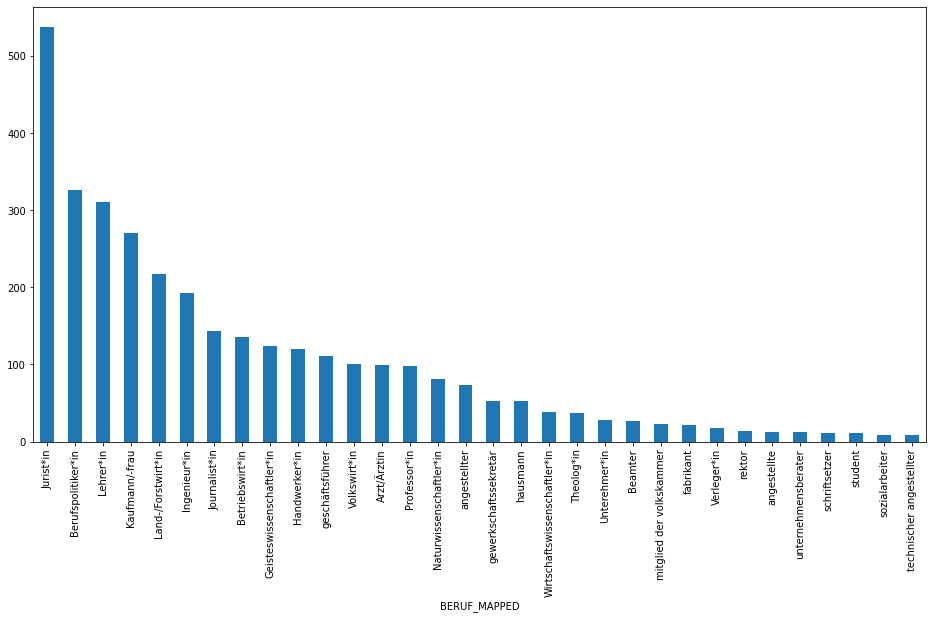

In [62]:
plt.figure(figsize=(16,8))
df_mdb.groupby('BERUF_MAPPED')['ID'].count().sort_values(ascending=False)[:32].plot(kind='bar')

In [63]:
len(set(df_mdb['BERUF_MAPPED']))

588

# construct df_mdb_wp

In [64]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 20)


In [65]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,12
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,13
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,14
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,15
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,16


# compute age

In [66]:
df_wp_startdaten = pd.read_csv('data/wp_startdaten.csv', index_col=0)
df_wp_startdaten

,START_DATE
1,1949-09-07
2,1953-10-06
3,1957-10-15
4,1961-10-17
5,1965-10-19
6,1969-10-20
7,1972-12-13
8,1976-12-14
9,1980-11-04
10,1983-03-29


In [67]:
df_wp_startdaten['START_DATE'] = pd.to_datetime(df_wp_startdaten['START_DATE'])

In [68]:
df_mdb_wp = df_mdb_wp.join(df_wp_startdaten, on='WP')

In [85]:
df_mdb_wp['START_DATE'] = pd.to_datetime(df_mdb_wp['START_DATE'])
df_mdb_wp['GEBURTSDATUM'] = pd.to_datetime(df_mdb_wp['GEBURTSDATUM'])

<AxesSubplot:>

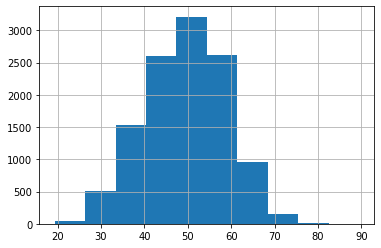

In [102]:
df_mdb_wp['START_AGE_IN_YEARS'].hist()

In [96]:
def match_age(x):
    if x < 30:
        return ('< 30')
    elif x < 40:
        return('30 - 40')
    elif x < 50:
        return('40 - 50')
    elif x < 60:
        return('50 - 60')
    elif x < 70:
        return('70 - 80')
    else:
        return('>= 80')

In [98]:
match_age(80)

'>= 80'

In [70]:
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_DATE'] - df_mdb_wp['GEBURTSDATUM']
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_AGE_IN_YEARS']/np.timedelta64(1,'Y')

df_mdb_wp

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP,START_DATE,START_AGE_IN_YEARS
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,5,1965-10-19,34.998665
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,6,1969-10-20,39.001485
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,7,1972-12-13,42.150078
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,8,1976-12-14,46.152898
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,9,1980-11-04,50.043464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,11004958,Nölke,Matthias,1980-08-01,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,"Mitgl. des Landesvorstands der FDP Hessen, Vor...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1980-08-01,konfessionslos,ledig,Jurist*in,19,2017-10-24,37.230059
4085,11004959,Martin,Dorothee,1978-01-21,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,1997 Abitur. Studium Politikwissenschaft und S...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1978-01-21,UNBEKANNT,UNBEKANNT,selbstständige kommunikationsberater,19,2017-10-24,39.757148
4086,11004960,Wetzel,Wolfgang,1968-11-05,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,Abschluss 10. Klasse POS. Ausbildung zum Krank...,None,1,1968-11-05,katholisch,"verh., 2 Kinder",Lehrer*in,19,2017-10-24,48.967467
4087,11004961,Natterer,Christian,1981-02-19,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,1992/98 Mittlere Reife am Bildungszentrum Bodn...,None,1,1981-02-19,katholisch,"verh., 1 Kind",Kaufmann/-frau,19,2017-10-24,36.677002


<AxesSubplot:>

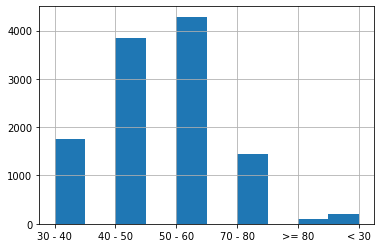

In [103]:
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'] = df_mdb_wp['START_AGE_IN_YEARS'].apply(lambda x: match_age(x)) 
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'].hist()

In [111]:
list_of_altersklassen = sorted(list(set(df_mdb_wp['START_AGE_IN_YEARS_MAPPED'])))
list_of_altersklassen = ['< 30', '30 - 40', '40 - 50', '50 - 60', '70 - 80',  '>= 80']
list_of_altersklassen

['< 30', '30 - 40', '40 - 50', '50 - 60', '70 - 80', '>= 80']

# save as csv

In [105]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [72]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [73]:
df_mdb.columns

Index(['ID', 'NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT',
       'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION',
       'BERUF', 'PARTEI_KURZ', 'VITA_KURZ', 'VEROEFFENTLICHUNGSPFLICHTIGES',
       'ANZ_WAHLPERIODEN', '5', '6', '7', '8', '9', '10', '11', '3', '4', '2',
       '12', '13', '14', '15', '16', '1', '17', '18', '19', 'GEBURSDATUM_DATE',
       'RELIGION_MAPPED', 'FAMILIENSTAND_MAPPED', 'BERUF_MAPPED'],
      dtype='object')

In [74]:
df_mdb.tail()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,15,16,1,17,18,19,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED
4084,11004958,Nölke,Matthias,08.01.1980,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,NaN,NaN,NaN,NaN,NaN,1.0,1980-08-01,konfessionslos,ledig,Jurist*in
4085,11004959,Martin,Dorothee,21.01.1978,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,1.0,1978-01-21,UNBEKANNT,UNBEKANNT,selbstständige kommunikationsberater
4086,11004960,Wetzel,Wolfgang,11.05.1968,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,1.0,1968-11-05,katholisch,"verh., 2 Kinder",Lehrer*in
4087,11004961,Natterer,Christian,19.02.1981,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,1.0,1981-02-19,katholisch,"verh., 1 Kind",Kaufmann/-frau
4088,11004962,Dahmen,Janosch,06.09.1981,UNBEKANNT,UNBEKANNT,UNBEKANNT,männlich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,1.0,1981-06-09,UNBEKANNT,UNBEKANNT,Arzt/Ärztin


In [75]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

,ID
WP,
19,738
18,658
17,652
16,642
15,628


# quality checks

In [76]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP,START_DATE,START_AGE_IN_YEARS
603,11000198,Bleser,Peter,1952-07-23,Brachtendorf,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 3 Kinder",römisch-katholisch,...,1959/67 Volksschule. 1967/70 Ausbildung im elt...,"3 Funktionen in Unternehmen: \ninnogy SE, Spar...",8,1952-07-23,katholisch,"verh., 3 Kinder",Land-/Forstwirt*in,19,2017-10-24,65.255276
1878,11000616,Fuchtel,Hans-Joachim,1952-02-13,Sulz am Neckar,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 4 Kinder",evangelisch,...,Studium der Rechtswissenschaft und Wirtschafts...,"5 Funktionen in Vereinen, Verbänden und Stiftu...",9,1952-02-13,evangelisch,"verh., >3 Kinder",Berufspolitiker*in,19,2017-10-24,65.696079
3351,11001074,Kauder,Volker,1949-03-09,Hoffenheim,UNBEKANNT,UNBEKANNT,männlich,verheiratet,evangelisch,...,"Abitur 1969, Hegau-Gymnasium Singen. 1969/71 W...",2 Entgeltliche Tätigkeiten neben dem Mandat: \...,8,1949-03-09,evangelisch,verh.,Jurist*in,19,2017-10-24,68.628377
3952,11001278,Landgraf,Katharina,1954-02-24,"Kirchengel / Krs Sondershausen, Bezirk Erfurt",UNBEKANNT,UNBEKANNT,weiblich,"verheiratet, 4 Kinder",evangelisch-lutherisch,...,1972 Abitur in Borna. 1972/76 Studium Meliorat...,3 Funktionen in Unternehmen: \nLeipziger Symph...,5,1954-02-24,evangelisch,"verh., >3 Kinder",Ingenieur*in,19,2017-10-24,63.664552
4595,11001478,Merkel,Angela,1954-07-17,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,...,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,19,2017-10-24,63.273031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11596,11004924,Vieregge,Kerstin,1976-06-09,Rinteln,UNBEKANNT,UNBEKANNT,weiblich,ledig,evangelisch-reformiert,...,"Realschule Extertal, Wirtschaftsabitur am Hans...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1976-06-09,evangelisch,ledig,Betriebswirt*in,19,2017-10-24,41.375251
11597,11004926,Vries,Christoph,1974-04-12,Hamburg,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 3 Kinder",römisch-katholisch,...,1994 Abitur an der katholischen Sankt-Ansgar-S...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1974-04-12,katholisch,"verh., 3 Kinder",Geisteswissenschaftler*in,19,2017-10-24,43.535459
11604,11004934,Wiesmann,Bettina Margarethe,1966-10-20,Berlin,UNBEKANNT,UNBEKANNT,weiblich,"verheiratet, 4 Kinder",evangelisch-lutherisch,...,"1984 Abitur und Baccalauréat, Berlin. 1987 Dip...",NaN,1,1966-10-20,evangelisch,"verh., >3 Kinder",unternehmensberater,19,2017-10-24,51.012683
11608,11004938,Ziemiak,Paul,1985-06-09,Stettin,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,"1998 Eintritt in die Junge Union, seit 2001 Mi...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1985-06-09,katholisch,"verh., 2 Kinder",angestellter,19,2017-10-24,32.375750


In [77]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP,START_DATE,START_AGE_IN_YEARS
8903,11003035,Baumann,Günter,1947-01-08,Annaberg-Buchholz,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",evangelisch-lutherisch,...,NaN,NaN,5,1947-01-08,evangelisch,"verh., 2 Kinder",Ingenieur*in,18,2013-10-22,66.788504
9406,11003264,Willsch,Klaus-Peter,1961-02-28,Bad Schwalbach,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 5 Kinder",evangelisch,...,Abitur 1979 in Wiesbaden. 1980/86 Studium Volk...,2 Entgeltliche Tätigkeiten neben dem Mandat: \...,6,1961-02-28,evangelisch,"verh., >3 Kinder",Volkswirt*in,18,2013-10-22,52.647214
9696,11003562,Kaster,Bernhard,1957-01-11,Trier,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",katholisch,...,NaN,NaN,4,1957-01-11,katholisch,"verh., 2 Kinder",Berufspolitiker*in,18,2013-10-22,56.778716
10272,11003801,Liebing,Ingbert,1963-11-05,Flensburg,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",evangelisch-lutherisch,...,NaN,NaN,3,1963-11-05,evangelisch,"verh., 2 Kinder",Berufspolitiker*in,18,2013-10-22,49.964065
10737,11004108,Mattfeldt,Andreas,1969-09-28,Verden (Aller),UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",UNBEKANNT,...,1989 Abitur. 1992 Berufsausbildung Industrieka...,2 Entgeltliche Tätigkeiten neben dem Mandat: \...,3,1969-09-28,UNBEKANNT,"verh., 2 Kinder",Kaufmann/-frau,18,2013-10-22,44.066613
10793,11004135,Riebsamen,Lothar,1957-09-24,Schwäblishausen,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,"1967/74 Gymnasium Sigmaringen, Mittlere Reife....","5 Funktionen in Vereinen, Verbänden und Stiftu...",3,1957-09-24,katholisch,"verh., 2 Kinder",Berufspolitiker*in,18,2013-10-22,56.077811
10818,11004146,Schnieder,Patrick,1968-01-05,Kyllburg,UNBEKANNT,UNBEKANNT,männlich,verheiratet,römisch-katholisch,...,1987 Abitur. 1987/88 Grundwehrdienst. 1988/95 ...,3 Funktionen in Unternehmen: \nEuropa Miniköch...,3,1968-01-05,katholisch,verh.,Berufspolitiker*in,18,2013-10-22,45.796971
10906,11004187,Weiss,Sabine,1958-05-26,Duisburg,UNBEKANNT,UNBEKANNT,weiblich,geschieden,römisch-katholisch,...,Bischöfliches Abteigymnasium und Leibniz-Gymna...,Keine veröffentlichungspflichtigen Angaben,3,1958-05-26,katholisch,gesch.,Jurist*in,18,2013-10-22,55.409762
10991,11004262,Donth,Michael,1967-08-06,Metzingen,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 3 Kinder",römisch-katholisch,...,Grundwehrdienst in Dornstadt. Studium an der F...,3 Funktionen in Unternehmen: \nKreiskliniken R...,2,1967-08-06,katholisch,"verh., 3 Kinder",Berufspolitiker*in,18,2013-10-22,46.213132
11032,11004286,Haase,Christian,1966-06-05,Höxter,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,"Studium der Verwaltungswissenschaften, 1993 Ab...",3 Funktionen in Unternehmen: \nBürger Windpark...,2,1966-06-05,katholisch,"verh., 1 Kind",Berufspolitiker*in,18,2013-10-22,47.382219
